In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyro
import pyro.distributions as dist
import zuko
from tqdm import tqdm

sns.set(style="white", context="notebook", palette="deep", color_codes=True)

/home/cbd/.cache/pypoetry/virtualenvs/bayes-air-GdHwFLEb-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Generate a bunch of samples from a normal distribution
torch.manual_seed(0)
pyro.set_rng_seed(0)
N_nominal = 25
N_failure = 2
nominal_mean = 0.0
failure_mean = 1.0
std = 0.5

nominal_samples = torch.normal(nominal_mean, std, (N_nominal,))
failure_samples = torch.normal(failure_mean, std, (N_failure,))

df = pd.concat(
    [
        pd.DataFrame({"x": nominal_samples, "type": "nominal"}),
        pd.DataFrame({"x": failure_samples, "type": "failure"}),
    ]
)

In [3]:
# Define the toy model
def original_model(n_samples, x=None):  # last arg needed for flow-based GAVI
    mean = pyro.sample("mean", dist.Normal(0.0, 100.0))
    sigma = torch.exp(pyro.sample("log_std", dist.Normal(0.0, 100.0)))

    with pyro.plate("data", n_samples):
        return pyro.sample("x", dist.Normal(mean, sigma), obs=x)

In [4]:
def elbo_loss(model, guide, context, num_particles=10, *model_args, **model_kwargs):
    elbo = torch.tensor(0.0)
    guide_dist = guide(context)
    for _ in range(num_particles):
        posterior_sample, posterior_logprob = guide_dist.rsample_and_log_prob()

        model_trace = pyro.poutine.trace(
            pyro.poutine.condition(
                model,
                data={
                    "mean": posterior_sample[0],
                    "log_std": posterior_sample[1],
                    # "mean": guide.mean,
                    # "log_std": guide.log_std,
                },
            )
        ).get_trace(*model_args, **model_kwargs)
        model_logprob = model_trace.log_prob_sum()

        elbo += (model_logprob - posterior_logprob) / num_particles

    return -elbo  #  negative to make it a loss


def kl_divergence(p, q, p_contexts, q_contexts, num_particles=10):
    # Make sure contexts have a batch dimension
    if p_contexts.ndim == 1:
        p_contexts = p_contexts.unsqueeze(0)
    
    if q_contexts.ndim == 1:
        q_contexts = q_contexts.unsqueeze(0)
    
    # Make sure contexts have the same shape
    if p_contexts.shape != q_contexts.shape:
        raise ValueError("Contexts must have the same shape")

    p_dist = p(p_contexts)
    q_dist = q(q_contexts)

    p_samples, p_logprobs = p_dist.rsample_and_log_prob((num_particles,))
    q_logprobs = q_dist.log_prob(p_samples)

    kl_divergence = (p_logprobs - q_logprobs).mean(dim=0)

    return kl_divergence

In [5]:
# Define hyperparams
num_steps = 1000
lr = 1e-3
grad_clip = 10.0
num_elbo_particles = 10
num_kl_divergence_particles = int(1e4)  # this can be vectorized easily
kl_divergence_weight = 10.0

  0%|          | 0/1000 [00:00<?, ?it/s]

Step 999 | ELBO: 31.231 | KL: 0.000 | Loss: 31.231: 100%|██████████| 1000/1000 [02:56<00:00,  5.65it/s]


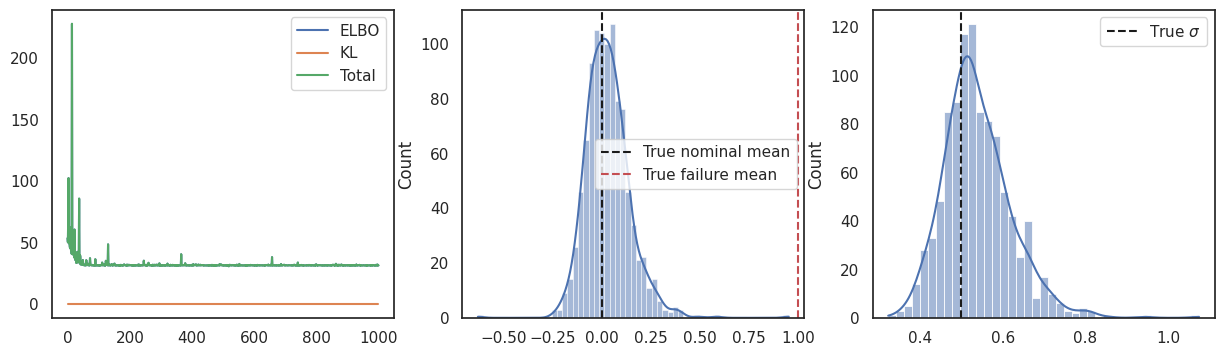

In [6]:
# Fit a nominal posterior using a normalizing flow
nominal_flow = zuko.flows.NSF(
    features=2, context=1, transforms=3, hidden_features=(64, 64)
)

# Fix the context
context = torch.tensor([0.0])

nominal_optim = torch.optim.Adam(nominal_flow.parameters(), lr=lr)
nominal_elbo_losses = []
nominal_kl_divergence = []
nominal_losses = []

pbar = tqdm(range(num_steps))
for step in pbar:
    nominal_optim.zero_grad()

    # Compute the loss components
    loss_components = {
        "elbo": elbo_loss(
            original_model,
            nominal_flow,
            context,
            num_elbo_particles,
            N_nominal,
            nominal_samples,
        ),
        "kl": torch.tensor(
            0.0
        ),  # Not tracking KL divergence for nominal model training
    }
    loss = loss_components["elbo"] + kl_divergence_weight * loss_components["kl"]

    # Step the optimizer
    loss.backward()
    torch.nn.utils.clip_grad_norm_(nominal_flow.parameters(), grad_clip)
    nominal_optim.step()

    # Record the losses
    nominal_elbo_losses.append(loss_components["elbo"].detach().item())
    nominal_kl_divergence.append(loss_components["kl"].detach().item())
    nominal_losses.append(loss.detach().item())

    pbar.set_description(
        f"Step {step} | "
        f"ELBO: {nominal_elbo_losses[-1]:.3f} | "
        f"KL: {nominal_kl_divergence[-1]:.3f} | "
        f"Loss: {nominal_losses[-1]:.3f}"
    )

# Plot the losses and the learned posterior
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(nominal_elbo_losses, label="ELBO")
axs[0].plot(nominal_kl_divergence, label="KL")
axs[0].plot(nominal_losses, label="Total")
axs[0].legend()

with torch.no_grad():
    posterior_samples = nominal_flow(context).sample((1000,))
    means = posterior_samples[:, 0]
    sigmas = torch.exp(posterior_samples[:, 1]).detach().numpy()
    sns.histplot(means, ax=axs[1], kde=True)
    sns.histplot(sigmas, ax=axs[2], kde=True)

axs[1].axvline(nominal_mean, color="k", linestyle="--", label="True nominal mean")
axs[1].axvline(failure_mean, color="r", linestyle="--", label="True failure mean")
axs[2].axvline(std, color="k", linestyle="--", label="True $\sigma$")
axs[1].legend()
axs[2].legend()

Step 0 | ELBO: 12.861 | KL: 9.321 | Loss: 12.861:   0%|          | 1/1000 [00:00<04:18,  3.87it/s]

Step 999 | ELBO: 11.052 | KL: 13.262 | Loss: 11.052: 100%|██████████| 1000/1000 [03:58<00:00,  4.20it/s]


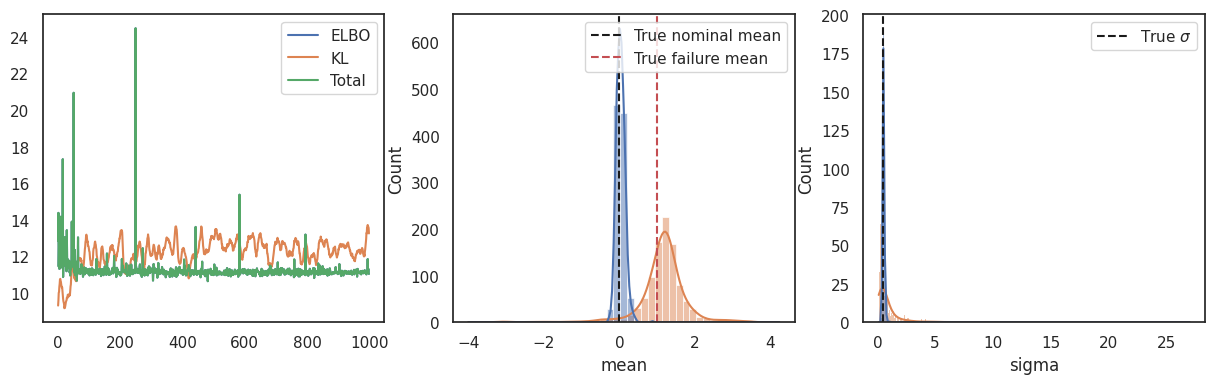

In [7]:
# Fit a failure posterior using a normalizing flow
failure_flow = zuko.flows.NSF(
    features=2, context=1, transforms=3, hidden_features=(64, 64)
)

# Fix the context
context = torch.tensor([0.0])

failure_optim = torch.optim.Adam(failure_flow.parameters(), lr=lr)
failure_elbo_losses = []
failure_kl_divergence = []
failure_losses = []

pbar = tqdm(range(num_steps))
for step in pbar:
    failure_optim.zero_grad()

    # Compute the loss components
    loss_components = {
        "elbo": elbo_loss(
            original_model,
            failure_flow,
            context,
            num_elbo_particles,
            N_failure,
            failure_samples,
        ),
        "kl": kl_divergence(
            failure_flow,
            nominal_flow,
            context,
            context,
            num_kl_divergence_particles,
        ),
    }
    loss = loss_components["elbo"]

    # Step the optimizer
    loss.backward()
    torch.nn.utils.clip_grad_norm_(failure_flow.parameters(), grad_clip)
    failure_optim.step()

    # Record the losses
    failure_elbo_losses.append(loss_components["elbo"].detach().item())
    failure_kl_divergence.append(loss_components["kl"].detach().item())
    failure_losses.append(loss.detach().item())

    pbar.set_description(
        f"Step {step} | "
        f"ELBO: {failure_elbo_losses[-1]:.3f} | "
        f"KL: {failure_kl_divergence[-1]:.3f} | "
        f"Loss: {failure_losses[-1]:.3f}"
    )

# Plot the losses and the learned posterior
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(failure_elbo_losses, label="ELBO")
axs[0].plot(failure_kl_divergence, label="KL")
axs[0].plot(failure_losses, label="Total")
axs[0].legend()

with torch.no_grad():
    nominal_posterior_samples = nominal_flow(context).sample((1000,))
    nominal_means = nominal_posterior_samples[:, 0]
    nominal_sigmas = torch.exp(nominal_posterior_samples[:, 1]).detach().numpy()

    failure_posterior_samples = failure_flow(context).sample((1000,))
    failure_means = failure_posterior_samples[:, 0]
    failure_sigmas = torch.exp(failure_posterior_samples[:, 1]).detach().numpy()

    plotting_df = pd.concat(
        [
            pd.DataFrame(
                {"mean": nominal_means, "sigma": nominal_sigmas, "type": "Nominal"}
            ),
            pd.DataFrame(
                {"mean": failure_means, "sigma": failure_sigmas, "type": "Failure"}
            ),
        ]
    )

    sns.histplot(x="mean", hue="type", data=plotting_df, ax=axs[1], kde=True)
    sns.histplot(x="sigma", hue="type", data=plotting_df, ax=axs[2], kde=True)

axs[1].axvline(nominal_mean, color="k", linestyle="--", label="True nominal mean")
axs[1].axvline(failure_mean, color="r", linestyle="--", label="True failure mean")
axs[2].axvline(std, color="k", linestyle="--", label="True $\sigma$")
axs[1].legend()
axs[2].legend()

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 9999 (Max. KL limit 15.0) | ELBO: 15.759 | Max. KL: 4.222632884979248 | Loss: 17.077: 100%|██████████| 10000/10000 [2:34:52<00:00,  1.08it/s]                


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

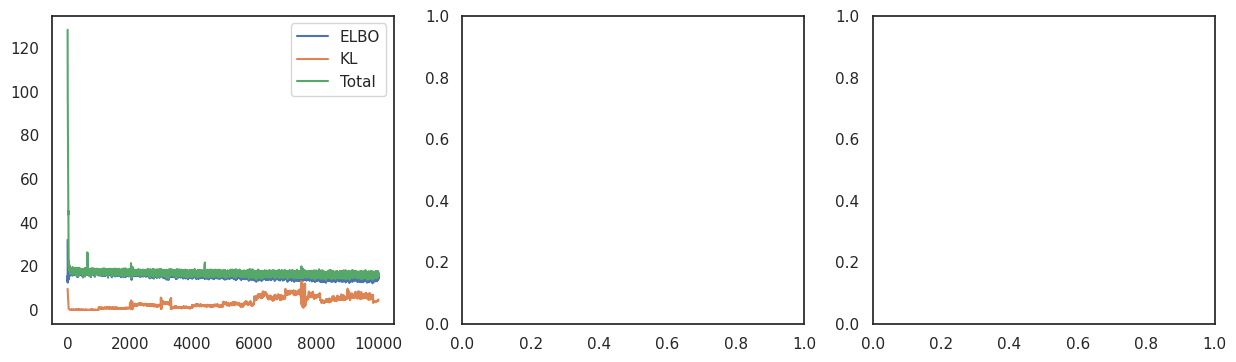

In [8]:
# Fit a failure posterior using a normalizing flow
failure_kl_flow = zuko.flows.NSF(
    features=2, context=1, transforms=3, hidden_features=(64, 64)
)

failure_optim = torch.optim.Adam(failure_kl_flow.parameters(), lr=lr)
failure_elbo_losses = []
failure_kl_divergence = []
failure_losses = []

max_kl = 15.0
kl_steps = 10
kl_limits = torch.linspace(0.0, max_kl, kl_steps)

pbar = tqdm(range(num_steps * kl_steps))
for step in pbar:
    failure_optim.zero_grad()

    batch_kl_limits = kl_limits[:step // num_steps + 1].reshape(-1, 1)

    # Compute the loss components
    loss_components = {
        "elbo": elbo_loss(
            original_model,
            failure_kl_flow,
            context,
            num_elbo_particles,
            N_failure,
            failure_samples,
        ),
        "kl": kl_divergence(
            failure_kl_flow,
            nominal_flow,
            batch_kl_limits,
            torch.zeros_like(batch_kl_limits),
            num_kl_divergence_particles,
        ),
    }
    loss = loss_components["elbo"] + kl_divergence_weight * torch.nn.functional.relu(
        loss_components["kl"] - batch_kl_limits.squeeze()
    ).mean()

    # Step the optimizer
    loss.backward()
    torch.nn.utils.clip_grad_norm_(failure_kl_flow.parameters(), grad_clip)
    failure_optim.step()

    # Record the losses
    failure_elbo_losses.append(loss_components["elbo"].detach().item())
    failure_kl_divergence.append(loss_components["kl"].detach().max())
    failure_losses.append(loss.detach().item())

    pbar.set_description(
        f"Step {step} (Max. KL limit {batch_kl_limits.max()}) | "
        f"ELBO: {failure_elbo_losses[-1]:.3f} | "
        f"Max. KL: {failure_kl_divergence[-1]} | "
        f"Loss: {failure_losses[-1]:.3f}"
    )

# Plot the losses and the learned posterior
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(failure_elbo_losses, label="ELBO")
axs[0].plot(failure_kl_divergence, label="KL")
axs[0].plot(failure_losses, label="Total")
axs[0].legend()

with torch.no_grad():
    nominal_posterior_samples = nominal_flow(torch.tensor(0.0)).sample((1000,))
    nominal_means = nominal_posterior_samples[:, 0]
    nominal_sigmas = torch.exp(nominal_posterior_samples[:, 1]).detach().numpy()

    failure_posterior_samples = failure_kl_flow(torch.tensor(0.0)).sample((1000,))
    failure_means = failure_posterior_samples[:, 0]
    failure_sigmas = torch.exp(failure_posterior_samples[:, 1]).detach().numpy()

    plotting_df = pd.concat(
        [
            pd.DataFrame(
                {"mean": nominal_means, "sigma": nominal_sigmas, "type": "Nominal"}
            ),
            pd.DataFrame(
                {"mean": failure_means, "sigma": failure_sigmas, "type": "Failure"}
            ),
        ]
    )

    sns.histplot(x="mean", hue="type", data=plotting_df, ax=axs[1], kde=True)
    sns.histplot(x="sigma", hue="type", data=plotting_df, ax=axs[2], kde=True)

axs[1].axvline(nominal_mean, color="k", linestyle="--", label="True nominal mean")
axs[1].axvline(failure_mean, color="r", linestyle="--", label="True failure mean")
axs[2].axvline(std, color="k", linestyle="--", label="True $\sigma$")
axs[1].legend()
axs[2].legend()

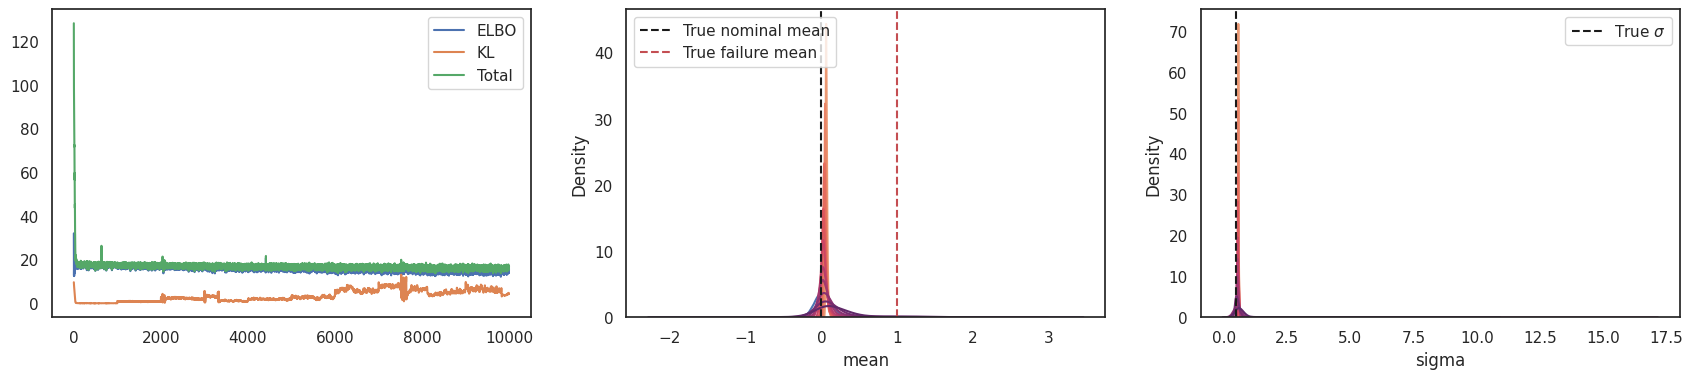

In [9]:
# Plot the losses and the learned posterior
fig, axs = plt.subplots(1, 3, figsize=(21, 4))
axs[0].plot(failure_elbo_losses, label="ELBO")
axs[0].plot(failure_kl_divergence, label="KL")
axs[0].plot(failure_losses, label="Total")
axs[0].legend()

with torch.no_grad():
    plotting_dfs = []

    nominal_posterior_samples = nominal_flow(torch.tensor([0.0])).sample((1000,))
    nominal_means = nominal_posterior_samples[:, 0]
    nominal_sigmas = torch.exp(nominal_posterior_samples[:, 1]).detach().numpy()
    plotting_dfs.append(
        pd.DataFrame(
            {
                "mean": nominal_means,
                "sigma": nominal_sigmas,
                "type": "Nominal",
                "kl_limit": 0.0,
            }
        )
    )

    for kl_limit in kl_limits:
        context = torch.tensor([kl_limit])
        failure_posterior_samples = failure_kl_flow(context).sample((1000,))
        failure_means = failure_posterior_samples[:, 0]
        failure_sigmas = torch.exp(failure_posterior_samples[:, 1]).detach().numpy()
        plotting_dfs.append(
            pd.DataFrame(
                {
                    "mean": failure_means,
                    "sigma": failure_sigmas,
                    "type": "Failure",
                    "kl_limit": kl_limit,
                }
            )
        )

    plotting_df = pd.concat(plotting_dfs)

plotting_df["kl_limit"] = plotting_df["kl_limit"].astype(str)
sns.kdeplot(
    x="mean",
    data=plotting_df[plotting_df.type == "Nominal"],
    ax=axs[1],
    common_norm=False,
)
sns.kdeplot(
    x="mean",
    hue="kl_limit",
    data=plotting_df[plotting_df.type == "Failure"],
    ax=axs[1],
    common_norm=False,
    palette="flare_r",
)
sns.kdeplot(
    x="sigma",
    hue="kl_limit",
    data=plotting_df[plotting_df.type == "Failure"],
    ax=axs[2],
    common_norm=False,
    palette="flare_r",
)

axs[1].axvline(nominal_mean, color="k", linestyle="--", label="True nominal mean")
axs[1].axvline(failure_mean, color="r", linestyle="--", label="True failure mean")
axs[2].axvline(std, color="k", linestyle="--", label="True $\sigma$")
axs[1].legend(loc="upper left")
axs[2].legend()